<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Blob by probability distribution fuction (PDFs) </b></span><br>
<span style="font-size: 16px;">
- Spectral analysis of blobs is often used to show the intermittency of blobs. <br>
- Skewness, Kurtosis might be different between NT and PT<br>
- The interpretation of positive and negative Skewness/Kurtosis is explained in my Evernote
</span>
</div>



In [5]:
import sys
sys.path.append('/marconi/home/userexternal/klim0000/my_venv/lib/python3.9/site-packages')
#from skimage.measure import label, regionprops

In [6]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as mcolors

from skimage import measure


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Read DN+NT $\delta=-0.6$ dataset </b></span><br>
</div>



In [7]:
#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

# Get the current working directory|
cwd = os.getcwd()

os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

Current working directory: /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6


In [9]:
t2= s.time[-1]-1
t1= t2 -5

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]


dens  = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
dens_avg  = np.mean(dens, axis=(2,3)); 
dens_avg_tor = np.mean(dens, axis=2)

dens_fluct_avg_NT=[]
for i in range(len(dens[0,0,0,:])):
    dens_fluct_NT   = np.sqrt((dens[:,:,0,i]-dens_avg_tor[:,:,i])**2) / dens_avg_tor[:,:,i]
    dens_fluct_avg_NT.append(dens_fluct_NT)


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>PDF in three different regions</b></span><br>
<span style="font-size: 16px;">
- (1) Core (2) Near SOL (3) Far SOL <br>
- Let's first find the index of each points 
</span>
</div>



In [37]:
print(s.iy0)

161


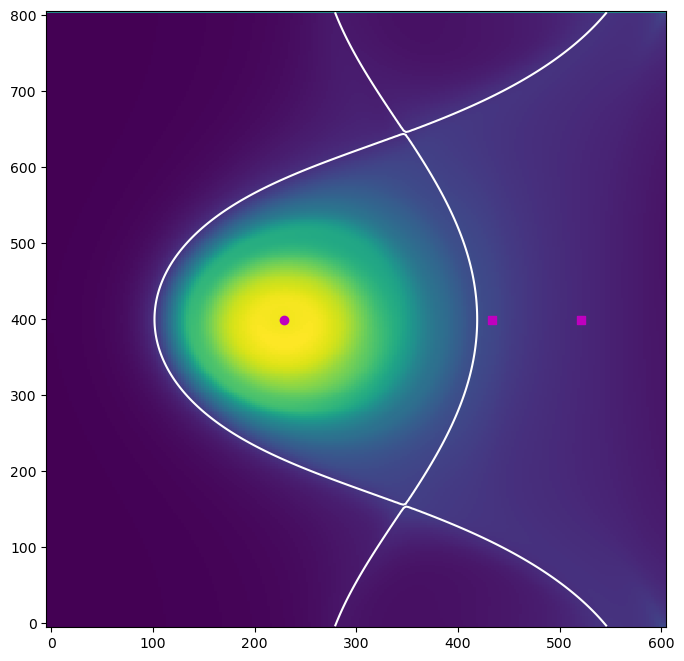

In [38]:
fig, ax = plt.subplots(dpi=100)
X, Y = np.meshgrid(s.x, s.y)
ax.pcolormesh(X, Y, dens_avg)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='w')
ax.scatter(x=s.x0, y=s.y0, c='m') # Core regoin
ax.scatter(x=s.x[175], y=s.y[s.iy0], c='m', marker='s') # Near SOL
ax.scatter(x=s.x[210], y=s.y[s.iy0], c='m', marker='s') # Far SOL

plt.show()

In [11]:
np.shape(dens_fluct_avg_NT)

(51, 324, 244)

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Define the mask in the SOL region </b></span><br>
</div>

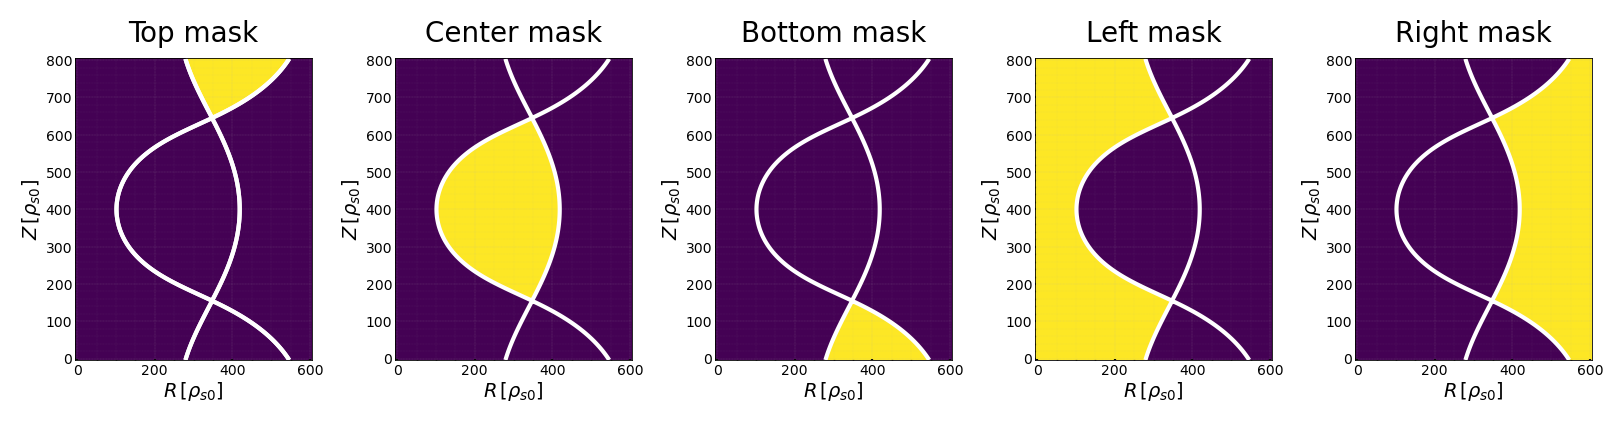

In [5]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=5,  figsize=(8, 2),  dpi=200, constrained_layout=True)

mask_contour=axes[0].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')

mask_bottom = mask_contour.collections[0].get_paths()[0]
mask_top    = mask_contour.collections[0].get_paths()[1]
mask_center = mask_contour.collections[0].get_paths()[2]

# Create a mask for points inside the contour path
inside_mask_bottom = mask_bottom.contains_points(np.column_stack([X.ravel(), Y.ravel()]))
inside_mask_top    = mask_top.contains_points(np.column_stack([X.ravel(), Y.ravel()]))
inside_mask_center = mask_center.contains_points(np.column_stack([X.ravel(), Y.ravel()]))

inside_mask_top    = inside_mask_top.reshape(X.shape)
inside_mask_center = inside_mask_center.reshape(X.shape)
inside_mask_bottom = inside_mask_bottom.reshape(X.shape)

# For left and right part
outside_mask = ~inside_mask_center & ~inside_mask_top & ~inside_mask_bottom

# Get the X coordinates that are to the left of the center region
left_outside_mask = outside_mask & (X < s.x[s.ixxpt])
right_outside_mask = outside_mask & (X > s.x[s.ixxpt])

# Reshape this mask to the original shape if necessary
left_outside_mask = left_outside_mask.reshape(X.shape)
right_outside_mask = right_outside_mask.reshape(X.shape)


# Plot the figure
cs1 = axes[0].pcolormesh(X, Y, inside_mask_top, cmap='viridis')
cs2 = axes[1].pcolormesh(X, Y, inside_mask_center, cmap='viridis')
cs3 = axes[2].pcolormesh(X, Y, inside_mask_bottom, cmap='viridis')
cs4 = axes[3].pcolormesh(X, Y, left_outside_mask, cmap='viridis')
cs5 = axes[4].pcolormesh(X, Y, right_outside_mask, cmap='viridis')

for ax in axes:
    ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')

for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

for ax in axes:
    ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
    ax.grid(True, which='minor', alpha=0.4, linestyle=':', linewidth=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=5, pad=1)
    ax.tick_params(axis='y', labelsize=5, pad=1)
    ax.tick_params(which='minor', direction="in", size=0.2)
    ax.tick_params(which='major', direction="in", size=0.5)
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=7, labelpad=1)
    ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=7, rotation=90, labelpad=1)
    #ax.legend(bbox_to_anchor=(0.35, 1), loc='upper right', edgecolor='white', prop={'size': 2}, facecolor='white' )
    
axes[0].set_title('Top mask', fontsize=10)
axes[1].set_title('Center mask', fontsize=10)
axes[2].set_title('Bottom mask', fontsize=10)
axes[3].set_title('Left mask', fontsize=10)
axes[4].set_title('Right mask', fontsize=10)

#plt.gca().set_aspect('equal')
plt.show(block=False)

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Detect blobs in NT far SOL </b></span><br>
</div>

In [6]:
import skimage
from skimage.measure import label, regionprops, find_contours

# Define time range for analysis
time_steps = dens.shape[-1]
time_interval = 0.1
# Structure to hold blob data over time
areas_NT = []; perimeters_NT = []; sizes_NT=[]; Nb_blobs_NT=[]

dens_fluct_avg_NT=[]
for i in range(len(dens[0,0,0,:])):
    dens_fluct_NT   = np.sqrt((dens[:,:,0,i]-dens_avg_tor[:,:,i])**2) / dens_avg_tor[:,:,i]
    dens_fluct_avg_NT.append(dens_fluct_NT)
    #print(np.shape(dens_fluct_NT))
# Normalized

for t in range(time_steps):
    
    # Threshold based on fluctuation
    threshold = 0.3 * np.max(dens_fluct_avg_NT[t])
    binary_image = dens_fluct_avg_NT[t] > threshold

    # Label the regions in the binary image
    labeled_image = label(binary_image)

    # Variables to store properties for the current time step
    areas = []
    perimeters = []
    sizes = []
    Nb_blobs=[]
    Nb_blobs_count=0

    # Calculate properties for each labeled region
    for region in regionprops(labeled_image):
        if region.area > 0:  # Adjust condition as necessary
            Nb_blobs_count += 1
            areas.append(region.area)
            perimeters.append(region.perimeter)
            sizes.append(region.major_axis_length * region.minor_axis_length)
            Nb_blobs.append(Nb_blobs_count)
    # Store properties for the current time step
    areas_NT.append(areas)
    perimeters_NT.append(perimeters)
    sizes_NT.append(sizes)
    Nb_blobs_NT.append(Nb_blobs)
    
    all_areas_NT = np.concatenate(areas_NT)
    all_perimeters_NT = np.concatenate(perimeters_NT)
    all_sizes_NT = np.concatenate(sizes_NT)
    all_Nb_blobs_NT = np.concatenate(Nb_blobs_NT)

from scipy.spatial.distance import cdist

centroids_over_time = []

# Assuming right_outside_mask and dens_fluct_avg_array are defined
time_interval = 1  # Adjust based on your actual data time resolution

# Extract centroids for blobs over time
for t in range(time_steps):  # Assuming time_steps is defined
    masked_dens_fluct = np.where(right_outside_mask, dens_fluct_avg_NT[t], np.nan)
    binary_image = masked_dens_fluct > threshold
    labeled_image = measure.label(binary_image)

    centroids = [region.centroid for region in measure.regionprops(labeled_image) if right_outside_mask[int(region.centroid[0]), int(region.centroid[1])]]
    centroids_over_time.append(centroids)

    # Initialize lists to store velocities
    all_velocities_NT = []
    all_positive_x_velocities_NT = []

    # Calculate velocities
    for t in range(len(centroids_over_time) - 1):
        current_centroids = centroids_over_time[t]
        next_centroids = centroids_over_time[t + 1]

        if not current_centroids or not next_centroids:
            continue

        distances = cdist(current_centroids, next_centroids)

        for i, centroid in enumerate(current_centroids):
            if len(next_centroids) > i:
                closest_index = np.argmin(distances[i])
                closest_centroid = next_centroids[closest_index]

                # Calculate displacement
                displacement = np.array(closest_centroid) - np.array(centroid)

                # Calculate the norm of the displacement vector
                displacement_norm = np.linalg.norm(displacement)

                # Calculate the velocity
                velocity = displacement_norm / time_interval
                all_velocities_NT.append(velocity)

                # Calculate the x-component of velocity separately if needed
                x_velocity = displacement[1] / time_interval  # Assuming [0] is y, [1] is x
                if x_velocity > 0:
                    all_positive_x_velocities_NT.append(x_velocity)


# Now all_positive_x_velocities contains all positive x-velocities across all time steps
#print("All positive x-component velocities:", all_positive_x_velocities)


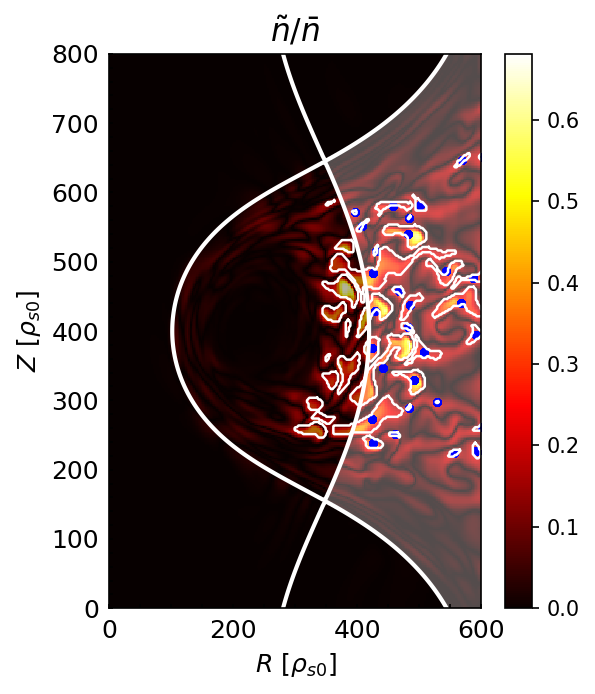

The total number of blobs in the masked region= 31


In [7]:
import skimage
from skimage.measure import label, regionprops, find_contours

X,Y = np.meshgrid(s.x, s.y)
    
# Visualize each contour on the original plot
fig, ax = plt.subplots(figsize=(4, 4.8), dpi=150)

cst=2.5
all_areas_NT = []; all_perimeters_NT = []; all_size_NT=[]; all_Nb_blobs_NT=[]
for t in range(time_steps):
    #Choose a threshold level (30% fluctuation)
    binary_image = dens_fluct_avg_NT[-1] > threshold

    # Label the regions in the binary image
    labeled_image = label(binary_image)

    # Find contours using the skimage measure module
    contours = measure.find_contours(binary_image.astype(float), 0.5)  # Use 0.5 since binary image is either 0 or 1

    Nb_blobs_NT = 0

    areas_NT = []
    perimeters_NT = []
    size_NT=[]
    # Calculate properties of each region
    for region in regionprops(labeled_image):

        # The centroid coordinates of the region
        centroid = region.centroid

        # The perimeter of the region in pixels
        perimeter = region.perimeter


        # The centroid coordinates (note the inversion of x and y for plotting)
        Y0, X0 = region.centroid

        # Convert centroid coordinates to indices
        X0_idx, Y0_idx = int(X0), int(Y0)

        # Check if the centroid is within the right side region
        if right_outside_mask[Y0_idx, X0_idx]:
            Nb_blobs_NT += 1
            # This centroid is inside the right side region, so plot it
            ax.plot(cst*X0, cst*Y0, 'bo', markersize=3)  # plot the centroid in blue

            # Calculate and store the area and perimeter if needed
            all_areas_NT.append(region.area)
            all_perimeters_NT.append(region.perimeter)
            all_size_NT.append(region.major_axis_length * region.minor_axis_length)
            all_Nb_blobs_NT.append(Nb_blobs_NT)

        # The length of the minor and major axis
        minor_axis_length = region.minor_axis_length
        major_axis_length = region.major_axis_length

        # The orientation of the ellipse
        orientation = region.orientation


    

# Velocity of the blobs
    
cs = ax.pcolormesh(X, Y, dens_fluct_avg_NT[-1], cmap='hot')
cbar = fig.colorbar(cs)
cs5 = ax.pcolormesh(X, Y, right_outside_mask, cmap='binary_r', alpha=0.3)


# Plot the separatrix
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='w', linewidths=2)
# Plot each contour
for contour in contours:
    # Since dens_fluct_avg is (Y, X), contour[:, 0] is Y, and contour[:, 1] is X
    ax.plot(cst*contour[:, 1], cst*contour[:, 0], linewidth=1.2, c='w')  # No need to adjust contour plotting orientation

# Set the axes labels
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=12, width=0.8, size=2, pad=5)
ax.set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=12)
ax.set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=12, rotation=90)
ax.set_title(r'$\tilde{n}/\bar{n}$', fontsize=15)
ax.set_xlim([0,600]); ax.set_ylim([0,800])

plt.show()

print("The total number of blobs in the masked region=", Nb_blobs_NT)


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Read DN+PT $\delta=+0.6$ dataset </b></span><br>
</div>

In [8]:
#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

# Get the current working directory|
cwd = os.getcwd()

os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DPT_d0p6')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

Current working directory: /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6


In [9]:
t2= s.time[-1]-1
t1= t2 -5

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]


dens  = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
dens_avg  = np.mean(dens, axis=(2,3)); 
dens_avg_tor = np.mean(dens, axis=2)

# Normalized
#dens_fluct_PT   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
#dens_fluct = dens[:,:,0,-1] - dens_avg
#dens_fluct_avg_PT = np.mean(dens_fluct_PT, axis=2)

dens_fluct_avg_PT=[]
for i in range(dens.shape[-1]):
    dens_fluct_PT   = np.sqrt((dens[:,:,0,i]-dens_avg_tor[:,:,i])**2) / dens_avg_tor[:,:,i]
    dens_fluct_avg_PT.append(dens_fluct_PT)

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Define the mask in the PT SOL region </b></span><br>
</div>

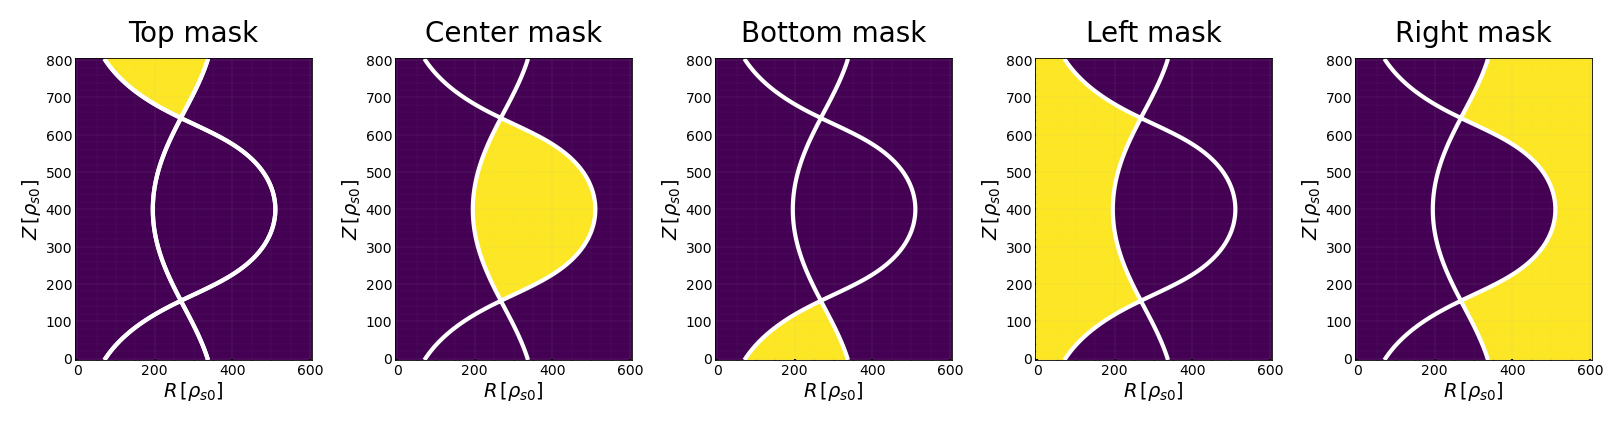

In [10]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=5,  figsize=(8, 2),  dpi=200, constrained_layout=True)

mask_contour=axes[0].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')

mask_bottom = mask_contour.collections[0].get_paths()[0]
mask_top    = mask_contour.collections[0].get_paths()[1]
mask_center = mask_contour.collections[0].get_paths()[2]

# Create a mask for points inside the contour path
inside_mask_bottom = mask_bottom.contains_points(np.column_stack([X.ravel(), Y.ravel()]))
inside_mask_top    = mask_top.contains_points(np.column_stack([X.ravel(), Y.ravel()]))
inside_mask_center = mask_center.contains_points(np.column_stack([X.ravel(), Y.ravel()]))

inside_mask_top    = inside_mask_top.reshape(X.shape)
inside_mask_center = inside_mask_center.reshape(X.shape)
inside_mask_bottom = inside_mask_bottom.reshape(X.shape)

# For left and right part
outside_mask = ~inside_mask_center & ~inside_mask_top & ~inside_mask_bottom

# Get the X coordinates that are to the left of the center region
left_outside_mask = outside_mask & (X < s.x[s.ixxpt])
right_outside_mask = outside_mask & (X > s.x[s.ixxpt])

# Reshape this mask to the original shape if necessary
left_outside_mask = left_outside_mask.reshape(X.shape)
right_outside_mask = right_outside_mask.reshape(X.shape)


# Plot the figure
cs1 = axes[0].pcolormesh(X, Y, inside_mask_top, cmap='viridis')
cs2 = axes[1].pcolormesh(X, Y, inside_mask_center, cmap='viridis')
cs3 = axes[2].pcolormesh(X, Y, inside_mask_bottom, cmap='viridis')
cs4 = axes[3].pcolormesh(X, Y, left_outside_mask, cmap='viridis')
cs5 = axes[4].pcolormesh(X, Y, right_outside_mask, cmap='viridis')

for ax in axes:
    ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')

for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

for ax in axes:
    ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
    ax.grid(True, which='minor', alpha=0.4, linestyle=':', linewidth=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=5, pad=1)
    ax.tick_params(axis='y', labelsize=5, pad=1)
    ax.tick_params(which='minor', direction="in", size=0.2)
    ax.tick_params(which='major', direction="in", size=0.5)
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=7, labelpad=1)
    ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=7, rotation=90, labelpad=1)
    #ax.legend(bbox_to_anchor=(0.35, 1), loc='upper right', edgecolor='white', prop={'size': 2}, facecolor='white' )
    
axes[0].set_title('Top mask', fontsize=10)
axes[1].set_title('Center mask', fontsize=10)
axes[2].set_title('Bottom mask', fontsize=10)
axes[3].set_title('Left mask', fontsize=10)
axes[4].set_title('Right mask', fontsize=10)

#plt.gca().set_aspect('equal')
plt.show(block=False)

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Detect blobs in PT far SOL </b></span><br>
</div>

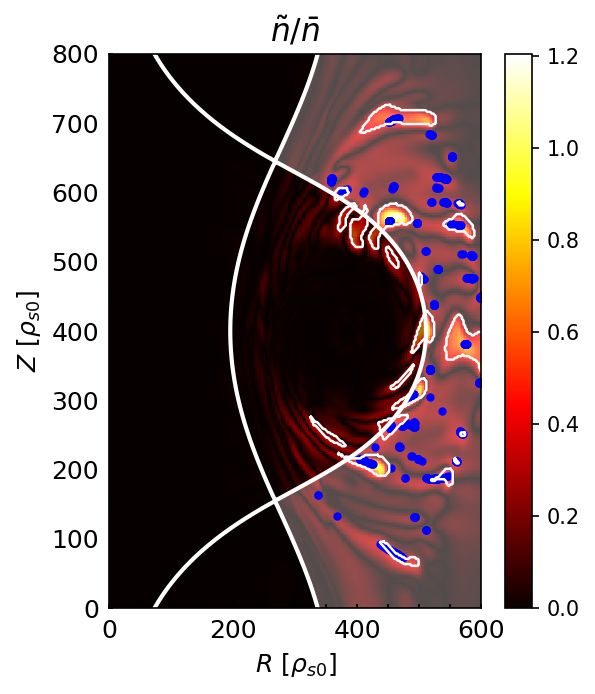

The total number of blobs in the masked region= 13


In [11]:
import skimage
from skimage.measure import label, regionprops, find_contours

X,Y = np.meshgrid(s.x, s.y)
    
# Visualize each contour on the original plot
fig, ax = plt.subplots(figsize=(4, 4.8), dpi=150)

cst=2.5
all_areas_PT = []; all_perimeters_PT = []; all_size_PT=[]; all_Nb_blobs_PT=[]
for t in range(time_steps):
    #Choose a threshold level (30% fluctuation)
    threshold = 0.3 * np.max(dens_fluct_avg_PT[t])
    binary_image = dens_fluct_avg_PT[-1] > threshold

    # Label the regions in the binary image
    labeled_image = label(binary_image)

    # Find contours using the skimage measure module
    contours = measure.find_contours(binary_image.astype(float), 0.5)  # Use 0.5 since binary image is either 0 or 1

    Nb_blobs_PT = 0

    areas_PT = []
    perimeters_PT = []
    size_PT=[]
    # Calculate properties of each region
    for region in regionprops(labeled_image):

        # The centroid coordinates of the region
        centroid = region.centroid

        # The perimeter of the region in pixels
        perimeter = region.perimeter


        # The centroid coordinates (note the inversion of x and y for plotting)
        Y0, X0 = region.centroid

        # Convert centroid coordinates to indices
        X0_idx, Y0_idx = int(X0), int(Y0)

        # Check if the centroid is within the right side region
        if right_outside_mask[Y0_idx, X0_idx]:
            Nb_blobs_PT += 1
            # This centroid is inside the right side region, so plot it
            ax.plot(cst*X0, cst*Y0, 'bo', markersize=3)  # plot the centroid in blue

            # Calculate and store the area and perimeter if needed
            all_areas_PT.append(region.area)
            all_perimeters_PT.append(region.perimeter)
            all_size_PT.append(region.major_axis_length * region.minor_axis_length)
            all_Nb_blobs_PT.append(Nb_blobs_PT)

        # The length of the minor and major axis
        minor_axis_length = region.minor_axis_length
        major_axis_length = region.major_axis_length

        # The orientation of the ellipse
        orientation = region.orientation


    

# Velocity of the blobs
    
cs = ax.pcolormesh(X, Y, dens_fluct_avg_PT[-1], cmap='hot')
cbar = fig.colorbar(cs)
cs5 = ax.pcolormesh(X, Y, right_outside_mask, cmap='binary_r', alpha=0.3)


# Plot the separatrix
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='w', linewidths=2)
# Plot each contour
for contour in contours:
    # Since dens_fluct_avg is (Y, X), contour[:, 0] is Y, and contour[:, 1] is X
    ax.plot(cst*contour[:, 1], cst*contour[:, 0], linewidth=1.2, c='w')  # No need to adjust contour plotting orientation

# Set the axes labels
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=12, width=0.8, size=2, pad=5)
ax.set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=12)
ax.set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=12, rotation=90)
ax.set_title(r'$\tilde{n}/\bar{n}$', fontsize=15)
ax.set_xlim([0,600]); ax.set_ylim([0,800])

plt.show()

print("The total number of blobs in the masked region=", Nb_blobs_PT)


In [12]:
import numpy as np
from scipy.spatial.distance import cdist

centroids_over_time = []

# Assuming right_outside_mask and dens_fluct_avg_array are defined
time_interval = 1  # Adjust based on your actual data time resolution

# Extract centroids for blobs over time
for t in range(time_steps):  # Assuming time_steps is defined
    masked_dens_fluct = np.where(right_outside_mask, dens_fluct_avg_PT[t], np.nan)
    binary_image = masked_dens_fluct > threshold
    labeled_image = measure.label(binary_image)

    centroids = [region.centroid for region in measure.regionprops(labeled_image) if right_outside_mask[int(region.centroid[0]), int(region.centroid[1])]]
    centroids_over_time.append(centroids)

    # Initialize lists to store velocities
    all_velocities_PT = []
    all_positive_x_velocities_PT = []

    # Calculate velocities
    for t in range(len(centroids_over_time) - 1):
        current_centroids = centroids_over_time[t]
        next_centroids = centroids_over_time[t + 1]

        if not current_centroids or not next_centroids:
            continue

        distances = cdist(current_centroids, next_centroids)

        for i, centroid in enumerate(current_centroids):
            if len(next_centroids) > i:
                closest_index = np.argmin(distances[i])
                closest_centroid = next_centroids[closest_index]

                # Calculate displacement
                displacement = np.array(closest_centroid) - np.array(centroid)

                # Calculate the norm of the displacement vector
                displacement_norm = np.linalg.norm(displacement)

                # Calculate the velocity
                velocity = displacement_norm / time_interval
                all_velocities_PT.append(velocity)

                # Calculate the x-component of velocity separately if needed
                x_velocity = displacement[1] / time_interval  # Assuming [0] is y, [1] is x
                if x_velocity > 0:
                    all_positive_x_velocities_PT.append(x_velocity)

# Now all_positive_x_velocities contains all positive x-velocities across all time steps
#print("All positive x-component velocities:", all_positive_x_velocities)


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Calculate PDFs </b></span><br>
</div>

In [13]:
from scipy.stats import gaussian_kde
from scipy.stats import skew, kurtosis
#import seaborn as sns

# NT
area_skewness_NT = skew(all_areas_NT)
area_kurtosis_NT = kurtosis(all_areas_NT)

perimeter_skewness_NT = skew(all_perimeters_NT)
perimeter_kurtosis_NT = kurtosis(all_perimeters_NT)

size_skewness_NT = skew(all_sizes_NT)
size_kurtosis_NT = kurtosis(all_sizes_NT)

#velocities_skewness_NT = skew(all_positive_x_velocities_NT)
#velocities_kurtosis_NT = kurtosis(all_positive_x_velocities_NT)

velocities_skewness_NT = skew(all_velocities_NT)
velocities_kurtosis_NT = kurtosis(all_velocities_NT)

# PT
area_skewness_PT = skew(all_areas_PT)
area_kurtosis_PT = kurtosis(all_areas_PT)

perimeter_skewness_PT = skew(all_perimeters_PT)
perimeter_kurtosis_PT = kurtosis(all_perimeters_PT)

size_skewness_PT = skew(all_size_PT)
size_kurtosis_PT = kurtosis(all_size_PT)

#velocities_skewness_PT = skew(all_positive_x_velocities_PT)
#velocities_kurtosis_PT = kurtosis(all_positive_x_velocities_PT)

velocities_skewness_PT = skew(all_velocities_PT)
velocities_kurtosis_PT = kurtosis(all_velocities_PT)

# Skewness and Kurtosis for NT and PT
skewness_kurtosis_NT = [
    (area_skewness_NT, area_kurtosis_NT),
    (size_skewness_NT, size_kurtosis_NT),
    (velocities_skewness_NT, velocities_kurtosis_NT)
]

skewness_kurtosis_PT = [
    (area_skewness_PT, area_kurtosis_PT),
    (size_skewness_PT, size_kurtosis_PT),
    (velocities_skewness_PT, velocities_skewness_PT)
]


<div class="alert alert-block alert-info">
<span style="font-size: 14px;"><b>Plotting PDF for Blob Areas </b></span><br>
</div>

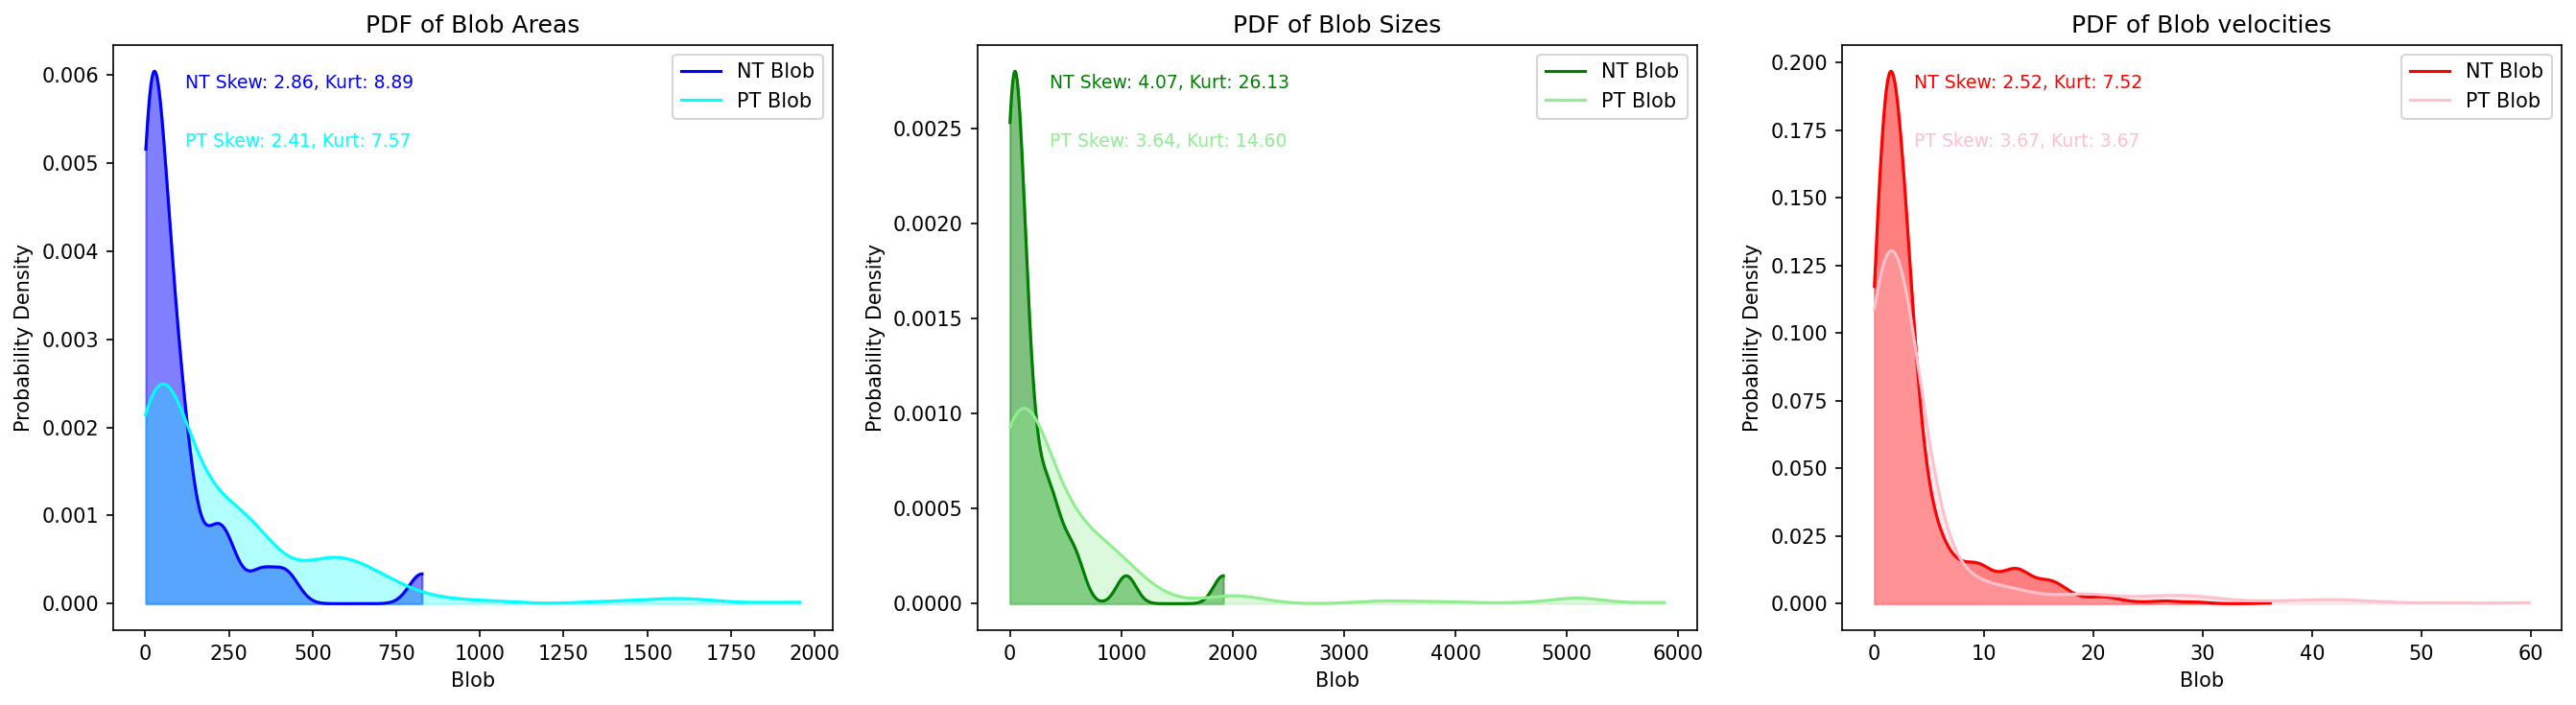

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# Set up the figure and axes for plotting, with increased DPI for better resolution
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), dpi=150)

# Titles for each subplot
titles = ['PDF of Blob Areas', 'PDF of Blob Sizes', 'PDF of Blob velocities']

# Data for NT and PT blobs
#data_NT = [all_areas_NT, all_size_NT, all_positive_x_velocities_NT]
#data_PT = [all_areas_PT, all_size_PT, all_positive_x_velocities_PT]
data_NT = [all_areas_NT, all_size_NT, all_velocities_NT]
data_PT = [all_areas_PT, all_size_PT, all_velocities_PT]
colors_NT = ['blue', 'green', 'red']  # Colors for NT blobs
colors_PT = ['cyan', 'lightgreen', 'pink']  # Colors for PT blobs

# Loop through each axis, and plot both NT and PT data
#for ax, datum_NT, datum_PT, color_NT, color_PT, title in zip(axes, data_NT, data_PT, colors_NT, colors_PT, titles):
for ax, datum_NT, datum_PT, color_NT, color_PT, title, sk_ku_NT, sk_ku_PT in zip(axes, data_NT, data_PT, colors_NT, colors_PT, titles, skewness_kurtosis_NT, skewness_kurtosis_PT):
    # Compute and plot for NT blobs
    kde_NT = gaussian_kde(datum_NT)
    data_range_NT = np.linspace(min(datum_NT), max(datum_NT), 500)
    pdf_NT = kde_NT(data_range_NT)
    ax.plot(data_range_NT, pdf_NT, label=f'NT {title.split(" ")[2]}', color=color_NT)
    ax.fill_between(data_range_NT, pdf_NT, color=color_NT, alpha=0.5)
    
    # Compute and plot for PT blobs
    kde_PT = gaussian_kde(datum_PT)
    data_range_PT = np.linspace(min(datum_PT), max(datum_PT), 500)
    pdf_PT = kde_PT(data_range_PT)
    ax.plot(data_range_PT, pdf_PT, label=f'PT {title.split(" ")[2]}', color=color_PT)
    ax.fill_between(data_range_PT, pdf_PT, color=color_PT, alpha=0.3)  # Slightly more transparent for overlap visibility

    # Add text annotations for skewness and kurtosis
    textstr_NT = f'NT Skew: {sk_ku_NT[0]:.2f}, Kurt: {sk_ku_NT[1]:.2f}'
    textstr_PT = f'PT Skew: {sk_ku_PT[0]:.2f}, Kurt: {sk_ku_PT[1]:.2f}'
    
    # Positioning the annotations within each subplot
    ax.text(0.1, 0.95, textstr_NT, transform=ax.transAxes, fontsize=9, verticalalignment='top', color=color_NT)
    ax.text(0.1, 0.85, textstr_PT, transform=ax.transAxes, fontsize=9, verticalalignment='top', color=color_PT)
    

    # General plot adjustments
    # General plot adjustments
    ax.set_title(title)
    ax.set_xlabel(title.split(' ')[2])
    ax.set_ylabel('Probability Density')
    ax.legend()

plt.tight_layout()
plt.show()
